Импортируем библиотеки.

In [1]:
from PIL import Image
import numpy as np
import os
import glob 
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, MaxPool2D
from keras.layers.convolutional import Conv2D
from keras.constraints import maxnorm
from keras.utils import to_categorical
import random
from tensorflow.keras.metrics import Metric
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns

Задаем имена классов.

In [2]:
class_names = [40, 42, 43, 45, 46, 47, 50, 51, 52, 53]

Считываем данные и делим на test и train выборки. При этом переводим картинки в 8-bit ч-б формат, уменьшаем размер вдвое и нормируем данные.

In [3]:
train_images_X = []
train_images_y = []
test_images_X = []
test_images_y = []
l = 0
for s in class_names: 
    names = glob.glob(f'sample{s}/*.png')
    imges = [Image.open(name).convert('L') for name in names] 
    j = 0
    for img in imges:
        j = j + 1 
        if j <= 69:
            train_images_X.append(np.array(img.resize(tuple([int(i/2) for i in img.size])))/256)
            train_images_y.append(l)
        else:
            test_images_X.append(np.array(img.resize(tuple([int(i/2) for i in img.size])))/256)
            test_images_y.append(l)
    l = l + 1
X_train = np.array(train_images_X)
y_train = to_categorical(np.array(train_images_y))
X_test = np.array(test_images_X)
y_test = to_categorical(np.array(test_images_y))
X_train = X_train.reshape(-1,100,100,1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 1/3, random_state=2)

Задаем модель для нашей нейронное сети. {Сверточный слой (с различной размерностью выходных пространств 8, 16, 32) => max пулинг (2 на 2 квадрат) => дропаут (каждый раз по 25%)}(трижды) => полносвязная двуслойная. Последний слой содержит столько выходов, сколько у нас классов и функцию активации softmax.

In [4]:
model = Sequential()
model.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (100,100,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

С целью увеличения способности модели к обобщению будем использовать ImageDataGenerator на изображениях тестового набора (поворот, смещение, переворот)

In [5]:
random.seed(1)

Выберем модель с оптимальным числом эпох и размером batch. Для этого используем ParameterGrid.

In [6]:
parameters = {'epochs': [24, 36, 48],
              'batch_size':[70, 84, 105, 140],
}

In [7]:
model.save_weights('start')
model.save_weights('best')
acc = 0
for i in list(ParameterGrid(parameters)):
    model.load_weights('start')
    random.seed(1)
    m = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=i['epochs'], batch_size=i['batch_size'], verbose=False)
    if m.history['val_accuracy'][-1] > acc:
        acc = m.history['val_accuracy'][-1]
        os.remove('best.index')
        model.save_weights('best')

Загрузим модель, которая показала лучшие результаты и проверим точность на тестовом наборе.

In [8]:
model.load_weights('best')
Y_pred = model.predict(X_test) 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 

m = tf.keras.metrics.Accuracy()
m.update_state(Y_true, Y_pred_classes)
print('Точность на тестовом наборе: ', m.result().numpy())

8/8 [==============================] - 0s 22ms/step
Точность на тестовом наборе:  0.93043476


Точность классификации составила 93%.
Также выведем confusion_matrix и проверим на каких классах чаще допускались ошибки.

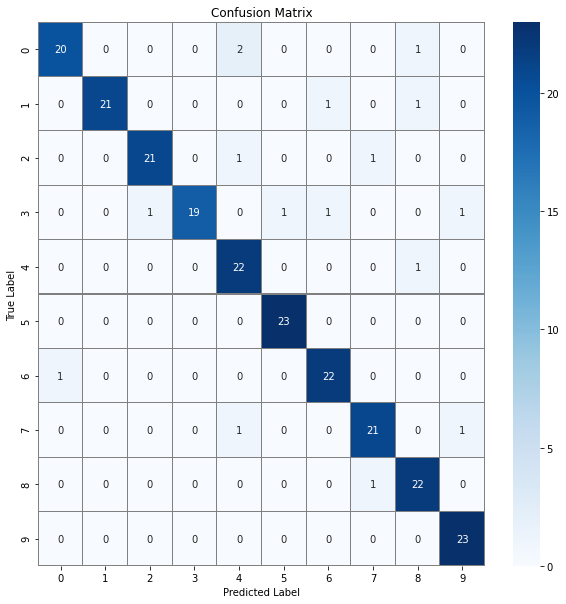

In [9]:
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.0f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

С целью увеличения способности модели к обобщению будем использовать ImageDataGenerator на изображениях тестового набора (поворот, смещение, переворот). Сравним с результатами без ImageDataGenerator.

In [10]:
random.seed(1)
datagen = ImageDataGenerator(
        featurewise_center=False,  # вычитание среднего
        samplewise_center=False,  # вычитание среднего
        featurewise_std_normalization=False,  # стандартизация
        samplewise_std_normalization=False,  # стандартизация
        zca_whitening=False,  # уменьшение размерности
        rotation_range=15,  # случайный поворот до 15 градусов
        zoom_range = 0.2, # случайное увеличение изображение до 20%
        width_shift_range=0.2,  # случайное смещение по горизонтали до 20%
        height_shift_range=0.2,  # случайное смещение по вертикали до 20%
        horizontal_flip=True,  # переворот по горизонтали
        vertical_flip=True)  # переворот по вертикали

datagen.fit(X_train)

In [11]:
random.seed(1)
parameters = {'epochs': [24, 36, 48],
              'batch_size':[70, 84, 105, 140],
}

In [12]:
parameters = {'epochs': [24, 36, 48],
              'batch_size':[70, 84, 105, 140],
}

In [13]:
model.save_weights('start')
model.save_weights('best')
acc = 0
for i in list(ParameterGrid(parameters)):
    model.load_weights('start')
    random.seed(1)
    m = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=i['epochs'], batch_size=i['batch_size'], verbose=False)
    if m.history['val_accuracy'][-1] > acc:
        acc = m.history['val_accuracy'][-1]
        os.remove('best.index')
        model.save_weights('best')

In [14]:
model.load_weights('best')
Y_pred = model.predict(X_test) 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 

m = tf.keras.metrics.Accuracy()
m.update_state(Y_true, Y_pred_classes)
print('Точность на тестовом наборе: ', m.result().numpy())

8/8 [==============================] - 0s 24ms/step
Точность на тестовом наборе:  0.95652175


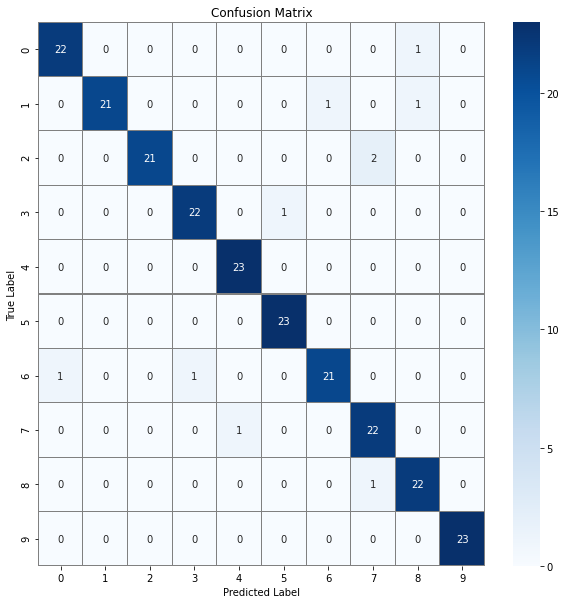

In [15]:
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.0f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Точность классификации составила 95.7% (против 93% без ImageDataGenerator).